In [5]:
#add code to path to be able to import is as a package
import sys
sys.path.insert(0,'../code')

In [53]:
import pandas as pd

import sys
import requests
import datetime as dt

#progress bars
from tqdm import tqdm 

#creating directories
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt



#additional libraries

import os
import zipfile
import numpy as np
from datetime import timedelta

# 1 Get the data about covid measures

In [44]:
def download_from_url(url, path):
    """
    Sends a request to a URI, opens a stream for downloading to a path
    
    Parameters
    ----------
    
    url: str
        url to download from
        
    path: str
        path, incl filename to store the data
    
    """
    
    response = requests.get(url, stream=True)

    with open(path, "wb") as out_file:
        for chunk in tqdm(response.iter_content(chunk_size=1024)):
            out_file.write(chunk)
    
    print("Done.")
    
    return
    
def create_filename(path_str, suffix, extension):
    """
    Method for unform data storage and filename handling
    """
      
    #create path for storing data
    Path(path_str).mkdir(parents=True, exist_ok=True)

    #timestamp
    t = str(dt.datetime.now())[:10]

    return path_str + t + '_' +  suffix + '.' +  extension

In [45]:
download_dir = '../data/raw/'
cleansed_dir = '../data/clean/'

In [66]:
#download the data

date_str = str(dt.datetime.now())[:10]
path_raw = download_dir + date_str +  'covid_datahub.csv'

url = 'https://storage.covid19datahub.io/data-1.csv'
download_from_url(url, path_raw)



3482it [00:00, 6095.53it/s]

Done.


### Idee: eerst gewoon covid infections plotten en R0 e.d. negeren

maar er is geen leeftijdsdata!! => mortality.org gebruiken voor death rates per leeftijd


* eerst time vs some alle restricties in area plot

* Data documentation: https://covid19datahub.io/articles/doc/data.html

    - school_closing:  0 - 3 
    - workplace_closing:  0 - 3 (essential jobs)
    - cancel_events: 0-2
    - gathering_restrictions: 0-4 (1000 people - 100.. )
    - transport_closing: 0-2 (public transport)
    - stay_home_restrictions 0-3
    - internal_movement_restrictions 0-2
    - international_movement restrictions 0-4
    - information_campaigns 0-2
    - testing policy 0-3
    - contact_tracing 0-2


In [87]:
df_datahub = pd.read_csv(path_raw)
MEASURES = list(df_datahub.columns[10:21])
df_datahub.columns



Index(['id', 'date', 'tests', 'confirmed', 'recovered', 'deaths', 'hosp',
       'vent', 'icu', 'population', 'school_closing', 'workplace_closing',
       'cancel_events', 'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'stringency_index', 'iso_alpha_3',
       'iso_alpha_2', 'iso_numeric', 'currency', 'administrative_area_level',
       'administrative_area_level_1', 'administrative_area_level_2',
       'administrative_area_level_3', 'latitude', 'longitude',
       'key_apple_mobility', 'key_google_mobility'],
      dtype='object')

['school_closing',
 'workplace_closing',
 'cancel_events',
 'gatherings_restrictions',
 'transport_closing',
 'stay_home_restrictions',
 'internal_movement_restrictions',
 'international_movement_restrictions',
 'information_campaigns',
 'testing_policy',
 'contact_tracing']

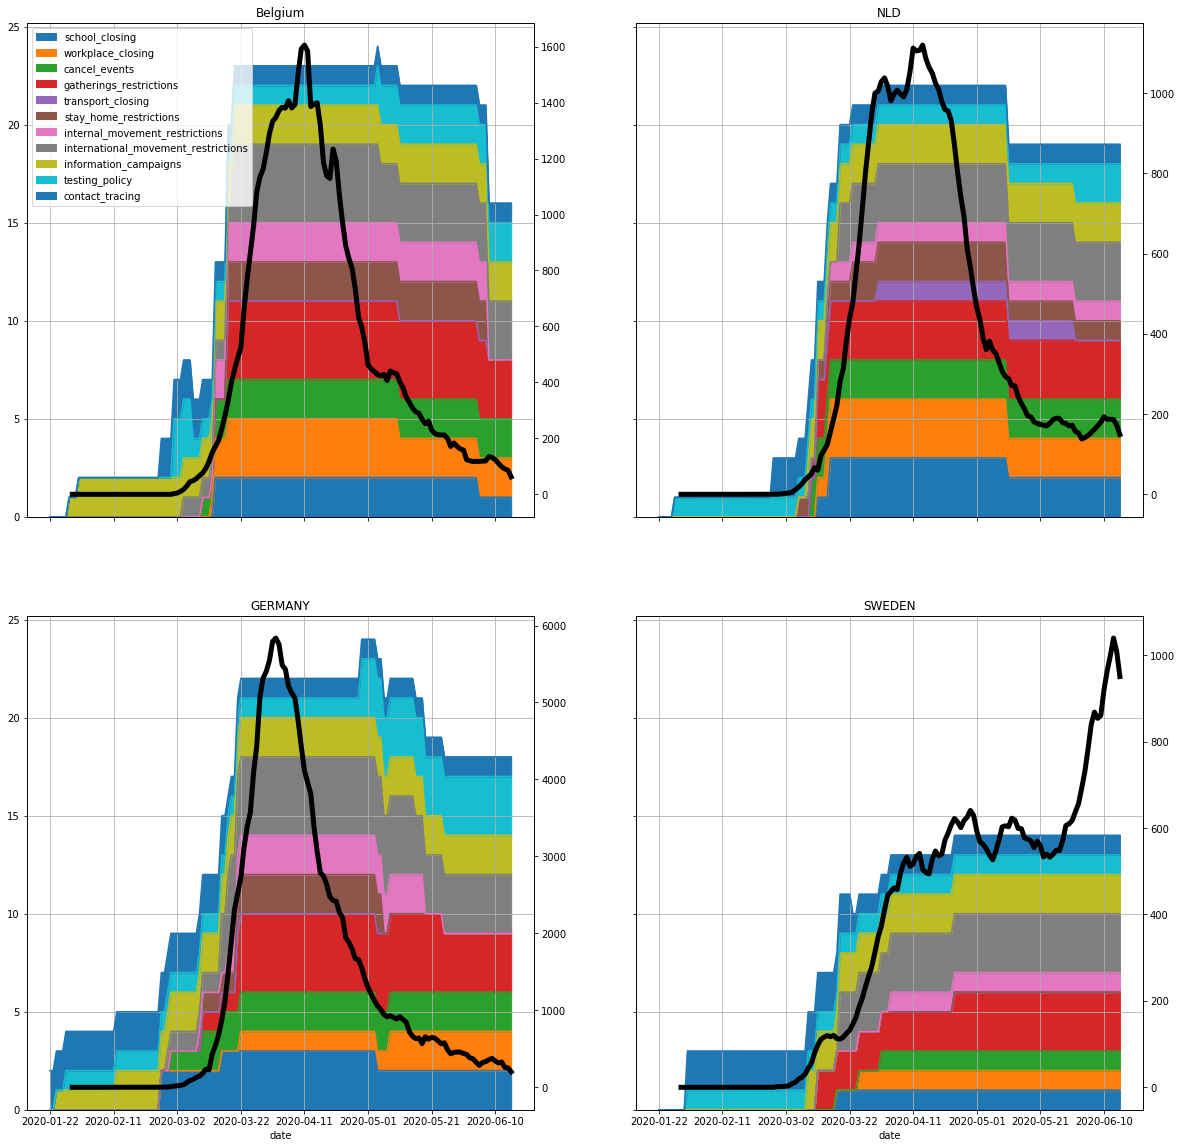

In [137]:
fig, ax = plt.subplots(2,2, figsize=(20,20), sharex=False, sharey=True)

mask_be = df_datahub['id'] == 'BEL'
df_be = pd.DataFrame(df_datahub[mask_be])
df_be.plot(kind='area', y=MEASURES, x='date', ax=ax[0][0], title="Belgium")
df_be['newcases'] = df_be['confirmed'].diff().rolling(7).mean()
df_be.plot(kind='line', y='newcases', x='date', ax=ax[0][0], secondary_y=True, 
           color='k', linewidth=5, legend=None, grid=True)


mask_be = df_datahub['id'] == 'NLD'
df_be = pd.DataFrame(df_datahub[mask_be])
df_be.plot(kind='area', y=MEASURES, x='date', ax=ax[0][1], title="NLD", legend=None)
df_be['newcases'] = df_be['confirmed'].diff().rolling(7).mean()
df_be.plot(kind='line', y='newcases', x='date', ax=ax[0][1], secondary_y=True, 
           color='k', linewidth=5, legend=None, grid=True)


mask_be = df_datahub['id'] == 'DEU'
df_be = pd.DataFrame(df_datahub[mask_be])
df_be.plot(kind='area', y=MEASURES, x='date', ax=ax[1][0], title="GERMANY", legend=None)
df_be['newcases'] = df_be['confirmed'].diff().rolling(7).mean()
df_be.plot(kind='line', y='newcases', x='date', ax=ax[1][0], secondary_y=True, 
           color='k', linewidth=5, legend=None, grid=True)


mask_be = df_datahub['id'] == 'SWE'
df_be = pd.DataFrame(df_datahub[mask_be])
df_be.plot(kind='area', y=MEASURES, x='date', ax=ax[1][1], title="SWEDEN", legend=None)
df_be['newcases'] = df_be['confirmed'].diff().rolling(7).mean()
df_be.plot(kind='line', y='newcases', x='date', ax=ax[1][1], secondary_y=True, 
           color='k', linewidth=5, legend=None, grid=True)


In [128]:
df_datahub[mask_be]['confirmed'].diff()

24090       NaN
24091       0.0
24092       0.0
24093       0.0
24094       0.0
          ...  
24231    1347.0
24232    1391.0
24233    1110.0
24234     243.0
24235     139.0
Name: confirmed, Length: 146, dtype: float64

In [120]:
df_be['confirmed'].diff().rolling(7).mean()

1752           NaN
1753           NaN
1754           NaN
1755           NaN
1756           NaN
           ...    
1893    110.857143
1894     98.571429
1895     90.714286
1896     86.142857
1897     62.428571
Name: confirmed, Length: 146, dtype: float64

## Plotting with two Y-axis
https://stackoverflow.com/questions/33678435/pandas-plotting-with-twinx

%matplotlib inline
from matplotlib import pyplot as plt

trend_df_hours = pd.Series(np.random.rand(10))
trend_df_qty = pd.Series(np.random.rand(10))

fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

trend_df_hours.plot(kind='bar', stacked=True, ax=ax0)
trend_df_qty.plot(kind='line', secondary_y=True, ax=ax1)
plt.show()
plt.close()